This project focuses on building a Convolutional Neural Network (CNN) using PyTorch to classify chest X-ray images into three categories: **Covid-19**, **Normal**, and **Viral Pneumonia**.
prediction of model shows: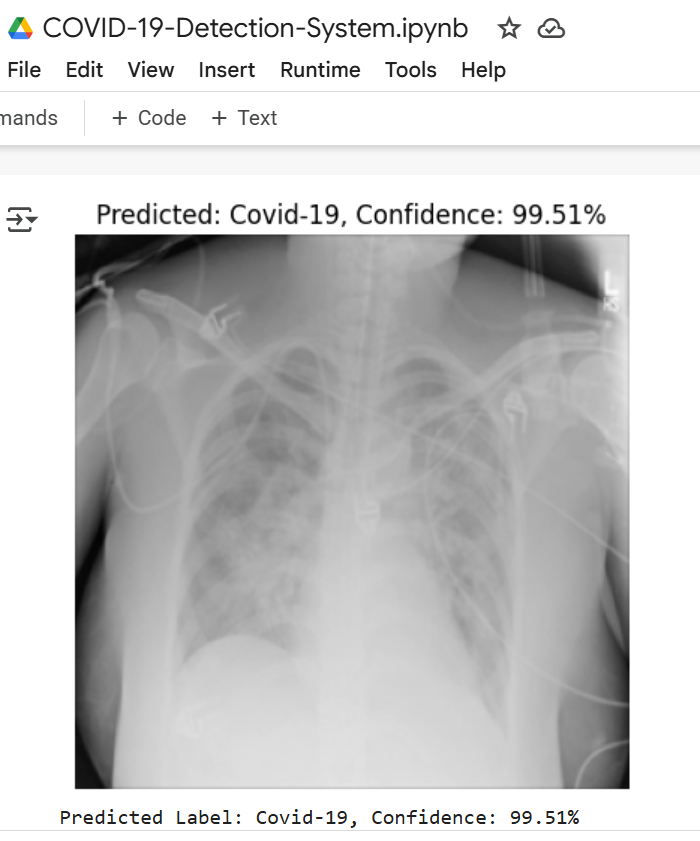

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pickle
from tqdm import tqdm

In [ ]:
from google.colab import files
files.upload()  # Then select kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sunnywazir","key":"af95b10575b265a72c26802daace3d94"}'}

In [ ]:
import os
import zipfile

# Make a .kaggle folder and move kaggle.json there
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database


Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 95% 738M/778M [00:03<00:00, 112MB/s] 
100% 778M/778M [00:04<00:00, 201MB/s]


In [ ]:
!unzip covid19-radiography-database.zip -d covid_data


Streaming output truncated to the last 5000 lines.
  inflating: covid_data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: covid_data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: covid_data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: covid_data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: covid_data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: covid_data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: covid_data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: covid_data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: covid_data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: covid_data/COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: covid_data/COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: covid_data/CO

In [ ]:
DATA_DIR = '/content/covid_data/COVID-19_Radiography_Dataset'


In [ ]:
# 2. Parameters
IMAGE_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = '/content/covid_data/COVID-19_Radiography_Dataset'
label_map = {'COVID': 'Covid-19', 'Normal': 'Normal', 'Viral Pneumonia': 'Pneumonia'}

In [ ]:
import os

DATA_DIR = '/content/covid_data/COVID-19_Radiography_Dataset'

for root, dirs, files in os.walk(DATA_DIR):
    print(f"📁 Folder: {root}")
    print(f"📂 Subfolders: {dirs}")
    print(f"📄 Files: {files[:5]}")  # Only show first 5 files
    print("─" * 50)


📁 Folder: /content/covid_data/COVID-19_Radiography_Dataset
📂 Subfolders: ['COVID', 'Lung_Opacity', 'Viral Pneumonia', 'Normal']
📄 Files: ['Normal.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx', 'COVID.metadata.xlsx', 'Lung_Opacity.metadata.xlsx', 'README.md.txt']
──────────────────────────────────────────────────
📁 Folder: /content/covid_data/COVID-19_Radiography_Dataset/COVID
📂 Subfolders: ['masks', 'images']
📄 Files: []
──────────────────────────────────────────────────
📁 Folder: /content/covid_data/COVID-19_Radiography_Dataset/COVID/masks
📂 Subfolders: []
📄 Files: ['COVID-3615.png', 'COVID-2801.png', 'COVID-264.png', 'COVID-1435.png', 'COVID-3055.png']
──────────────────────────────────────────────────
📁 Folder: /content/covid_data/COVID-19_Radiography_Dataset/COVID/images
📂 Subfolders: []
📄 Files: ['COVID-3615.png', 'COVID-2801.png', 'COVID-264.png', 'COVID-1435.png', 'COVID-3055.png']
──────────────────────────────────────────────────
📁 Folder: /content/covid_data/COVID-19_Radiog

In [ ]:
# 3. Custom Dataset
class XrayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [ ]:
# 4. Load Images and Labels (corrected)
def load_data(data_dir):
    image_paths = []
    labels = []

    for root, _, files in os.walk(data_dir):
        # Only look inside 'images' folders
        if os.path.basename(root) == 'images':
            # The label folder is the parent folder of 'images'
            label_key = os.path.basename(os.path.dirname(root))

            if label_key in label_map:
                label = label_map[label_key]
                for file in files:
                    if file.endswith('.png'):
                        image_paths.append(os.path.join(root, file))
                        labels.append(label)

    return image_paths, labels

image_paths, labels_raw = load_data(DATA_DIR)

In [ ]:
image_paths, labels_raw = load_data(DATA_DIR)
print(f"Total images: {len(image_paths)}")
print(f"Sample labels: {set(labels_raw)}")


Total images: 15153
Sample labels: {'Pneumonia', 'Normal', 'Covid-19'}


In [ ]:
print(f"Total images: {len(image_paths)}")

Total images: 15153


In [ ]:
import random

def sample_2k_images(image_paths, labels, total_samples=2000, ratios={'Covid-19': 0.3, 'Normal': 0.3, 'Pneumonia': 0.4}):
    label_to_indices = {}
    for i, label in enumerate(labels):
        label_to_indices.setdefault(label, []).append(i)

    sampled_indices = []
    for label, ratio in ratios.items():
        n_samples = int(total_samples * ratio)
        indices = label_to_indices[label]
        sampled_indices += random.sample(indices, n_samples)

    random.shuffle(sampled_indices)

    sampled_paths = [image_paths[i] for i in sampled_indices]
    sampled_labels = [labels[i] for i in sampled_indices]

    return sampled_paths, sampled_labels


In [ ]:
sampled_paths, sampled_labels = sample_2k_images(
    image_paths,
    labels_raw,
    total_samples=2000,
    ratios={'Covid-19': 0.3, 'Normal': 0.3, 'Pneumonia': 0.4}
)


In [ ]:
le = LabelEncoder()
labels_encoded = le.fit_transform(sampled_labels)

In [ ]:
# Save label encoder for later use
pickle.dump(le, open("label_encoder.pkl", "wb"))

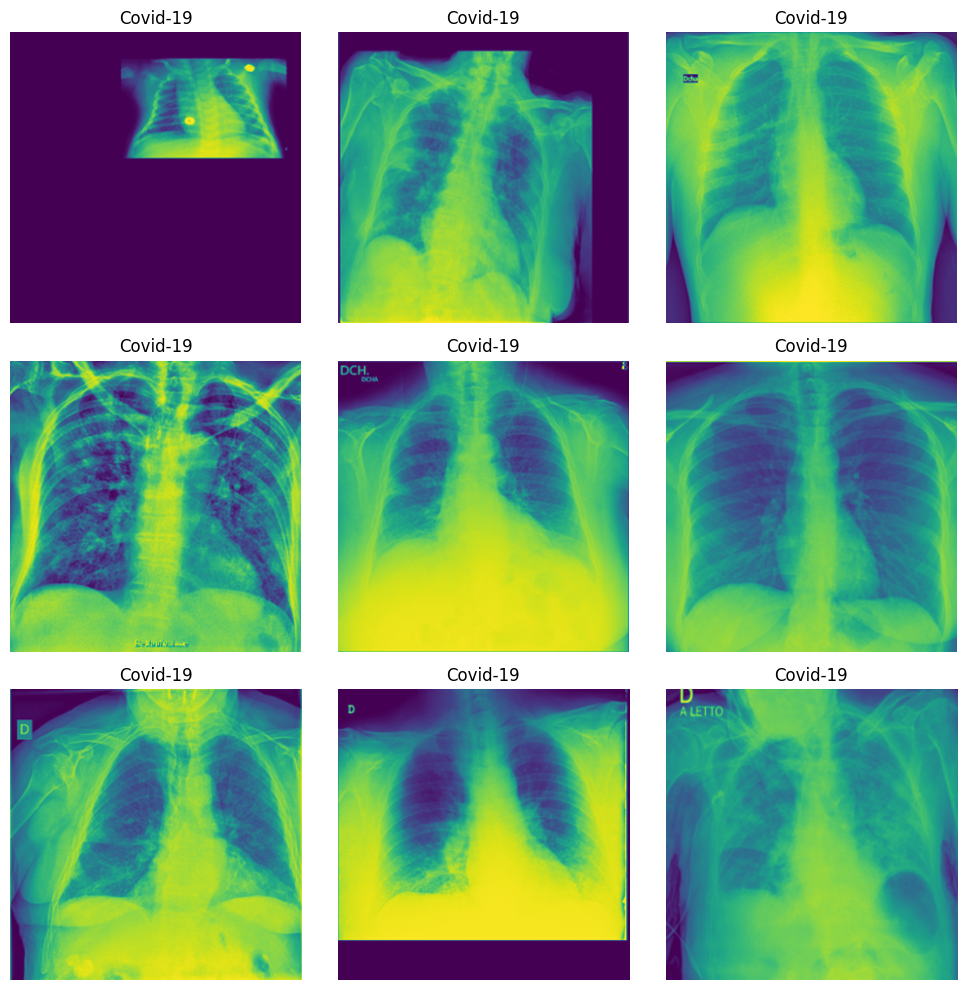

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Show 9 sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    image = Image.open(image_paths[i])
    label = labels_raw[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    sampled_paths, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

In [ ]:
# 6. Define Transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

In [ ]:
# Datasets
train_dataset = XrayDataset(train_paths, train_labels, transform)
val_dataset = XrayDataset(val_paths, val_labels, transform)
test_dataset = XrayDataset(test_paths, test_labels, transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [ ]:
# 8. Define CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 18 * 18, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))     # 75x75
        x = self.pool(F.relu(self.conv2(x)))     # 37x37
        x = self.pool(F.relu(self.conv3(x)))     # 18x18
        x = self.dropout(x)
        x = x.view(-1, 128 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
print(len(train_loader.dataset))  # should not be 0
print(len(val_loader.dataset))


1280
320


In [ ]:
# 9. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_acc_list, val_acc_list = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_acc_list.append(train_acc)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_acc_list.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return train_acc_list, val_acc_list


In [ ]:
train_acc_list, val_acc_list = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=EPOCHS)


Epoch [1/20], Train Acc: 0.6250, Val Acc: 0.7594
Epoch [2/20], Train Acc: 0.7719, Val Acc: 0.7688
Epoch [3/20], Train Acc: 0.8219, Val Acc: 0.8500
Epoch [4/20], Train Acc: 0.8656, Val Acc: 0.8688
Epoch [5/20], Train Acc: 0.8930, Val Acc: 0.8938
Epoch [6/20], Train Acc: 0.9117, Val Acc: 0.8656
Epoch [7/20], Train Acc: 0.9211, Val Acc: 0.9187
Epoch [8/20], Train Acc: 0.9141, Val Acc: 0.9125
Epoch [9/20], Train Acc: 0.9406, Val Acc: 0.9250
Epoch [10/20], Train Acc: 0.9563, Val Acc: 0.9313
Epoch [11/20], Train Acc: 0.9648, Val Acc: 0.8844
Epoch [12/20], Train Acc: 0.9688, Val Acc: 0.9156
Epoch [13/20], Train Acc: 0.9492, Val Acc: 0.8844
Epoch [14/20], Train Acc: 0.9523, Val Acc: 0.8750
Epoch [15/20], Train Acc: 0.9648, Val Acc: 0.9406
Epoch [16/20], Train Acc: 0.9828, Val Acc: 0.9250
Epoch [17/20], Train Acc: 0.9930, Val Acc: 0.9250
Epoch [18/20], Train Acc: 0.9898, Val Acc: 0.9156
Epoch [19/20], Train Acc: 0.9938, Val Acc: 0.9313
Epoch [20/20], Train Acc: 0.9891, Val Acc: 0.9313


In [ ]:
def plot_accuracy(train_acc_list, val_acc_list):
    import matplotlib.pyplot as plt

    plt.plot(train_acc_list, label="Train")
    plt.plot(val_acc_list, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.show()


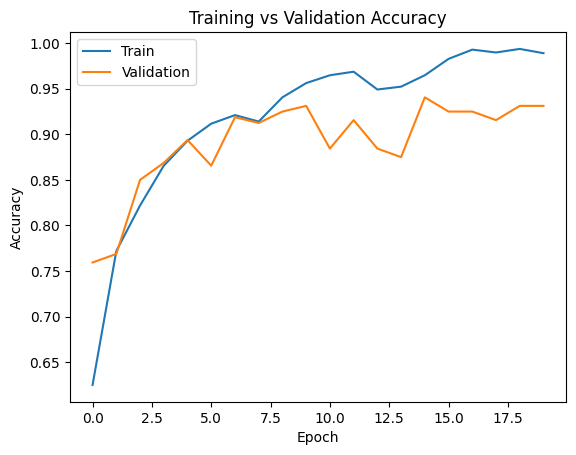

In [ ]:
plot_accuracy(train_acc_list, val_acc_list)

In [ ]:
def evaluate_model(model, test_loader, label_encoder, device):
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    import pandas as pd
    import matplotlib.pyplot as plt

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_), annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


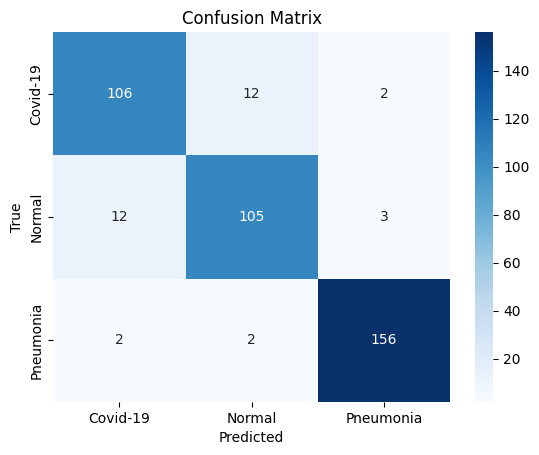

              precision    recall  f1-score   support

    Covid-19       0.88      0.88      0.88       120
      Normal       0.88      0.88      0.88       120
   Pneumonia       0.97      0.97      0.97       160

    accuracy                           0.92       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.92      0.92      0.92       400



In [ ]:
evaluate_model(model, test_loader, le, device)


In [ ]:
torch.save(model.state_dict(), "covid_classifier.pth")


In [ ]:
# Initialize the model architecture (same as before)
model = CNNModel(num_classes=3)

# Load the saved weights
model.load_state_dict(torch.load("covid_classifier.pth"))

# Set the model to evaluation mode
model.eval()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=41472, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

def detection_system_pytorch(image_path, model, label_encoder, image_size=150, device='cpu'):
    """
    Detection system for PyTorch model.

    Args:
    - image_path (str): Path to the input image.
    - model (torch.nn.Module): Trained PyTorch model.
    - label_encoder (LabelEncoder): Label encoder to decode predicted class.
    - image_size (int): Size to resize the image (image_size x image_size).
    - device (str): 'cpu' or 'cuda'.

    Returns:
    - predicted_label (str): Predicted class label.
    - confidence_score (float): Confidence score (probability).
    """

    # Load image using PIL (better for PyTorch transformations)
    image = Image.open(image_path).convert('RGB')

    # Define transforms same as training
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),  # converts to [0,1] and puts channels first
        # Add normalization here if used during training, e.g.:
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Preprocess image
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension: [1, C, H, W]
    input_tensor = input_tensor.to(device)

    # Set model to eval mode and predict
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)  # raw logits
        probabilities = torch.softmax(outputs, dim=1)
        confidence_score, predicted_idx = torch.max(probabilities, dim=1)

    predicted_label = label_encoder.inverse_transform(predicted_idx.cpu().numpy())[0]
    confidence_score = confidence_score.item()

    # Display the image with prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}, Confidence: {confidence_score*100:.2f}%")
    plt.axis('off')
    plt.show()

    return predicted_label, confidence_score


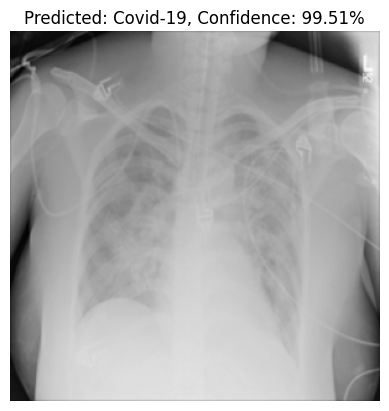

Predicted Label: Covid-19, Confidence: 99.51%


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

image_path = "/content/Lung_Opacity-10.png"
predicted_label, confidence = detection_system_pytorch(image_path, model, le, image_size=150, device=device)
print(f"Predicted Label: {predicted_label}, Confidence: {confidence*100:.2f}%")


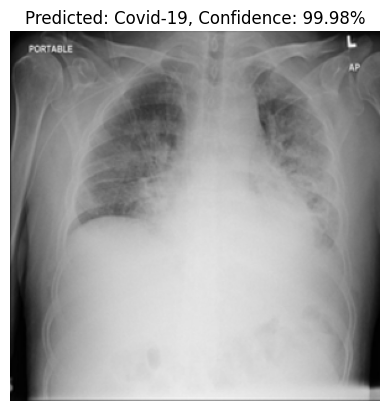

Predicted Label: Covid-19, Confidence: 99.98%


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

image_path = "/content/Lung_Opacity-1025.png"
predicted_label, confidence = detection_system_pytorch(image_path, model, le, image_size=150, device=device)
print(f"Predicted Label: {predicted_label}, Confidence: {confidence*100:.2f}%")
